In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# 1 Creating a News-Based Geopolitical Risk Index

We will use a Kaggle dataset of newspaper headlines from 10 major sources from 2007–2022 to create a ‘geopolitical’ risk index similar to Caldara and Iacoviello’s Geo-Political Risk Index (GPR).

In [3]:
headlines_df = pd.read_csv('headlines.csv')
headlines_df


,Date,Publication,Headline,URL
0,20070101,New York Times,Rush to Hang Hussein Was Questioned,http://www.nytimes.com/2007/01/01/world/middle...
1,20070101,New York Times,"News Analysis: For Sunnis, Dictators End Is O...",http://www.nytimes.com/2007/01/01/world/middle...
2,20070101,New York Times,Hard Choices Over Video,http://www.nytimes.com/2007/01/01/world/middle...
3,20070101,New York Times,States Take Lead on Ethics Rules for Lawmakers,http://www.nytimes.com/2007/01/01/us/01ethics....
4,20070101,New York Times,"Spitzer Arrives With Mandate, but Faces Challe...",http://www.nytimes.com/2007/01/01/nyregion/01e...
...,...,...,...,...
4405392,20230101,The Guardian,2023 in books Highlights for the year ahead,https://www.theguardian.com/books/2022/dec/31/...
4405393,20230101,The Guardian,The best hopeful films for a new year,https://www.theguardian.com/film/2022/dec/31/s...
4405394,20230101,The Guardian,Obituary Barbara Walters,https://www.theguardian.com/tv-and-radio/2022/...
4405395,20230101,The Guardian,Barbara Walters,https://www.theguardian.com/tv-and-radio/2022/...


## 1.1 Descriptive Statistics

Download the headlines data and inspect it. Provide some basic descriptive statistics about the headlines by answering the following questions:

### 1.1.1 How many articles are published every day? each month? Are there any outliers? How stable is the data?

/var/folders/cf/1wy60mt16_d0n286_h30f6nh0000gn/T/ipykernel_23609/3802165864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  headlines_df['Date'] = pd.to_datetime(headlines_df['Date'], format='%Y%m%d')


Articles Per Day:
count    5845.000000
mean      746.174166
std       125.195657
min       406.000000
25%       700.000000
50%       779.000000
75%       830.000000
max       914.000000
dtype: float64

Articles Per Month:
count      193.000000
mean     22597.865285
std       4098.560381
min        724.000000
25%      21767.000000
50%      23687.000000
75%      25041.000000
max      27710.000000
dtype: float64


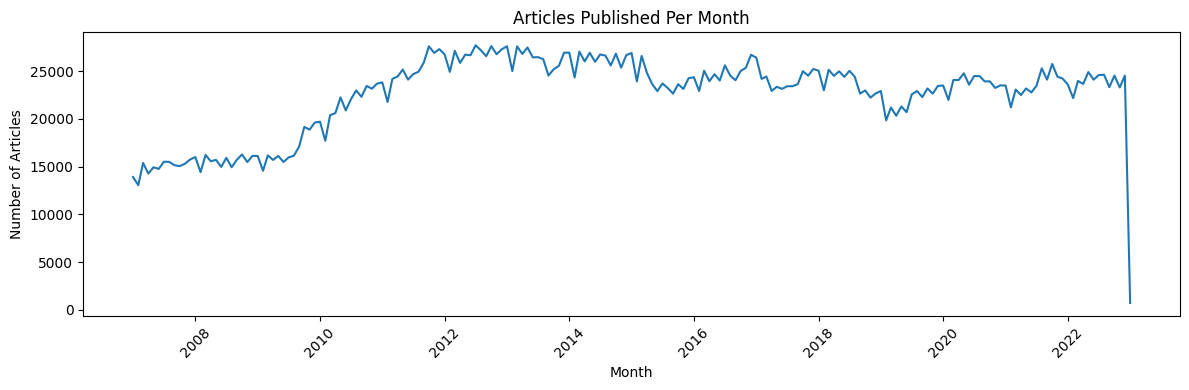

In [6]:
# Convert date column to datetime
headlines_df['Date'] = pd.to_datetime(headlines_df['Date'], format='%Y%m%d')

# Drop rows with missing headlines (optional but good practice)
headlines_df = headlines_df.dropna(subset=['Headline'])

# ----- Daily Article Count -----
articles_per_day = headlines_df.groupby(headlines_df['Date'].dt.date).size()

# Summary statistics
print("Articles Per Day:")
print(articles_per_day.describe())

# ----- Monthly Article Count -----
articles_per_month = headlines_df.groupby(headlines_df['Date'].dt.to_period('M')).size()
articles_per_month.index = articles_per_month.index.to_timestamp()

# Summary statistics
print("\nArticles Per Month:")
print(articles_per_month.describe())

# ----- Visualization -----
plt.figure(figsize=(12, 4))
sns.lineplot(x=articles_per_month.index, y=articles_per_month.values)
plt.title("Articles Published Per Month")
plt.ylabel("Number of Articles")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- The data is fairly stable on a day-to-day level. Most days fall between 700–830 articles, suggesting a relatively consistent publishing pace. A few outliers on the lower end (e.g., 406 articles) may be due to data gaps or slower news days.
- There's more variability on a monthly basis. While most months have 21k–25k articles, a few (e.g., only 724 articles) are extreme outliers—probably due to partial data coverage or incomplete month records (common in scraped datasets).

### 1.1.2 Which newspaper publishes the most? Why do you think this is?

/var/folders/cf/1wy60mt16_d0n286_h30f6nh0000gn/T/ipykernel_23609/3415909432.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_publishers.values, y=top_publishers.index, palette="muted")


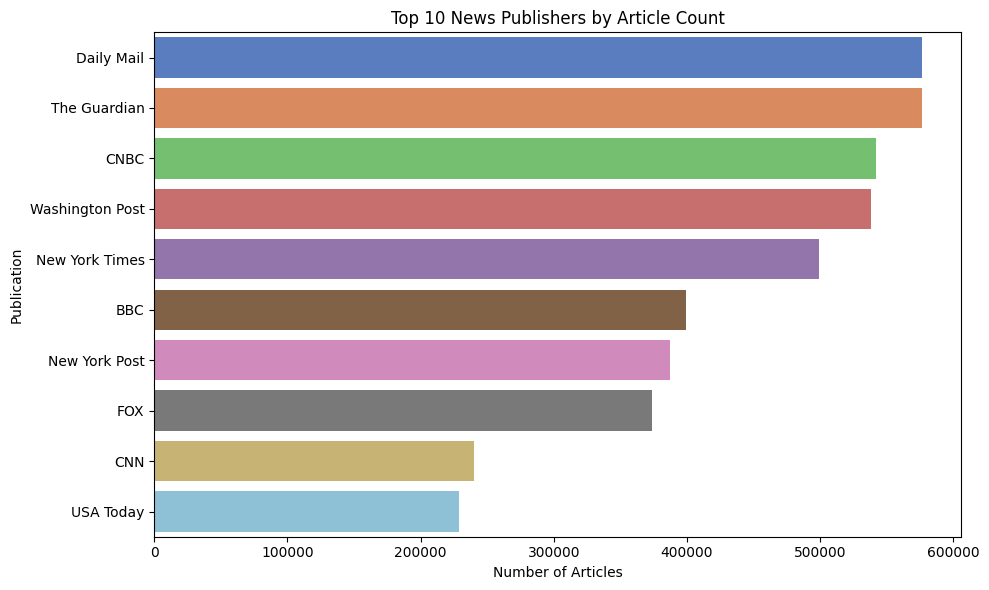

In [7]:
# Bar plot of top 10 publishers by article count
top_publishers = headlines_df['Publication'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_publishers.values, y=top_publishers.index, palette="muted")
plt.title("Top 10 News Publishers by Article Count")
plt.xlabel("Number of Articles")
plt.ylabel("Publication")
plt.tight_layout()
plt.show()

- The Daily Mail publishes the most headlines overall. Its content model—frequent, short updates often driven by trending topics—may drive its high output.
- The Guardian, CNBC, and Washington Post follow closely, likely due to large editorial teams and high daily publishing rates.
- CNN and USA Today appear lower despite being major outlets, possibly reflecting:
  - Dataset scraping limitations (e.g. fewer archived or accessible headlines)
  - Differences in RSS/metadata structure during data collection
  - Different editorial strategies (e.g. fewer but more in-depth stories)

### 1.1.3 Which newspaper has the shortest headlines? longest headlines?

In [8]:
# Add a column for headline length
headlines_df['Headline_Length'] = headlines_df['Headline'].apply(len)

# Group by publication and calculate headline length stats
headline_stats = headlines_df.groupby('Publication')['Headline_Length'].agg(['mean', 'min', 'max']).sort_values(by='mean', ascending=False)

# Display top and bottom few
headline_stats_rounded = headline_stats.round(2)

headline_stats_rounded

,mean,min,max
Publication,,,
Daily Mail,90.82,1,697
USA Today,67.52,2,644
New York Times,57.25,1,63773
FOX,54.24,1,319
New York Post,51.83,3,296
The Guardian,51.36,2,1806
Washington Post,46.59,2,357
CNBC,46.24,1,255
CNN,37.22,1,727


- The Daily Mail stands out for extremely long headlines—possibly due to its clickbait style or stacked descriptors.
- BBC consistently produces shorter, more concise headlines, likely reflecting its editorial style rooted in traditional broadcasting.
- Outliers exist (e.g., NYT max: 63,773 characters), suggesting some data noise—possibly concatenated articles or metadata errors.

### 1.1.4 Answer **just one** of the following:

- Using **TF-IDF**, identify the most distinctive headline words in each newspaper. Plot these in a word cloud, bar plot, or other visualization.
- Apply **doc2vec** to compare newspaper articles across the ten sources and plot a similarity matrix. What newspapers are most similar? Dissimilar? Why?

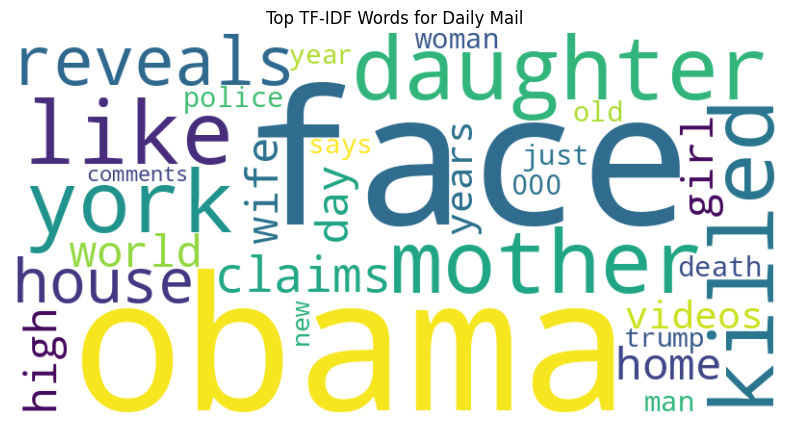

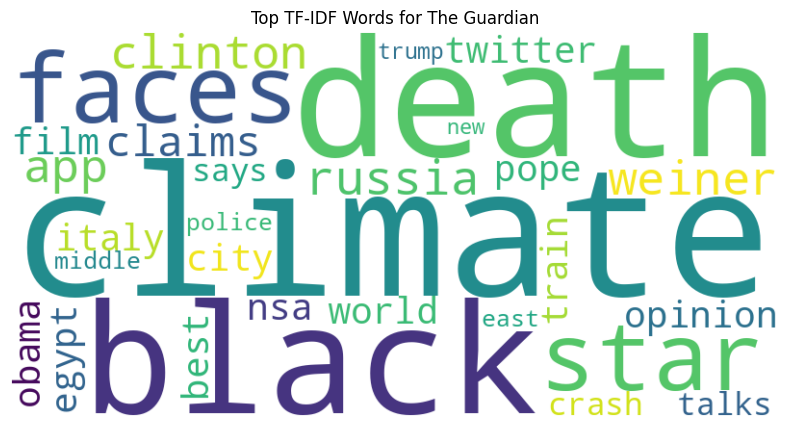

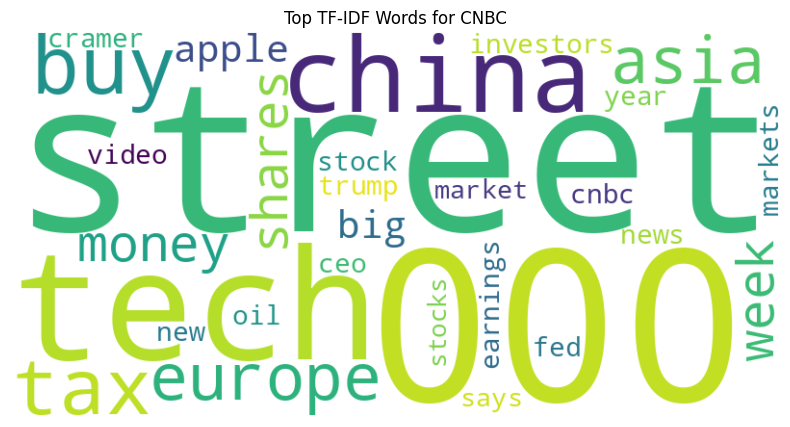

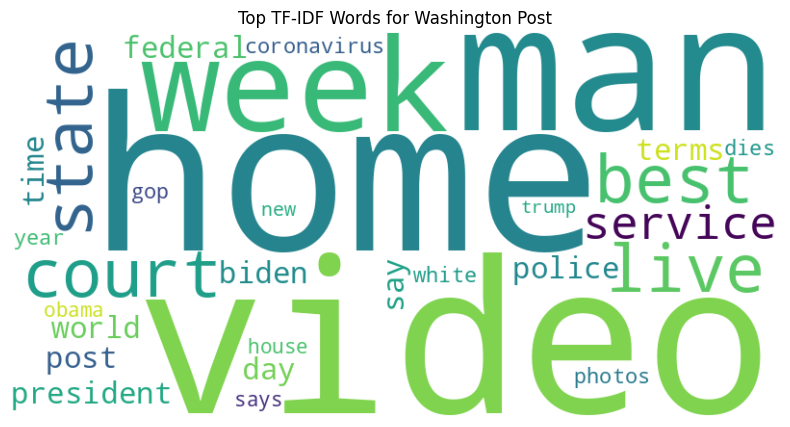

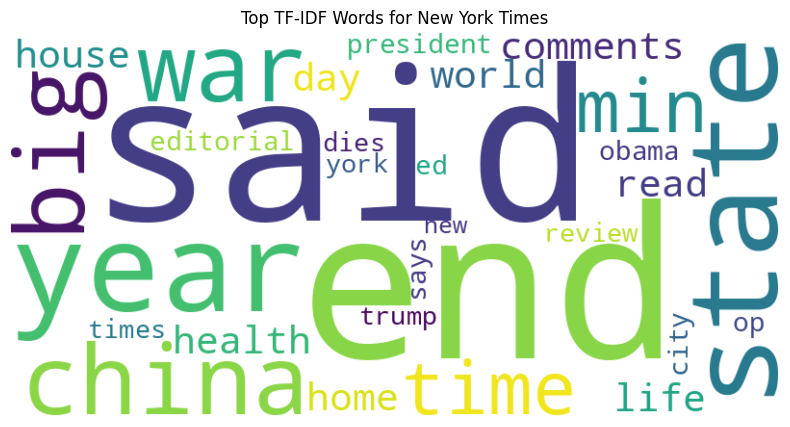

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Focus on top 5 publishers to keep it clear
top_publishers = headlines_df['Publication'].value_counts().head(5).index.tolist()
subset_df = headlines_df[headlines_df['Publication'].isin(top_publishers)]

# Create a dictionary to hold TF-IDF results per publication
top_words_per_pub = {}

# Loop through each top publisher
for pub in top_publishers:
    pub_headlines = subset_df[subset_df['Publication'] == pub]['Headline'].astype(str)
    tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = tfidf.fit_transform(pub_headlines)
    tfidf_scores = tfidf.idf_
    words = tfidf.get_feature_names_out()
    word_scores = dict(zip(words, tfidf_scores))
    
    # Sort and take top 30 distinctive words (lowest idf)
    top_words = dict(sorted(word_scores.items(), key=lambda item: item[1])[:30])
    top_words_per_pub[pub] = top_words

    # Plot word cloud
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top TF-IDF Words for {pub}")
    plt.show()


## 1.2 Text Cleaning

Use `spaCy`, `nltk`, and any other relevant libraries to clean the headlines. Outline the steps and justify what parts of speech you choose to keep.

In [12]:
!python -m spacy download en_core_web_sm

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.3 MB/s eta 0:00:0000:010:01
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [23]:
# Due to the large size of the dataset and computational constraints, I use a stratified random sample of 50,000 headlines to explore patterns and build a prototype of the index. This ensures fast iteration while maintaining coverage across different news sources and time periods.

headlines_sample = headlines_df.groupby('Publication', group_keys=False).apply(lambda x: x.sample(min(len(x), 5000), random_state=42))

/var/folders/cf/1wy60mt16_d0n286_h30f6nh0000gn/T/ipykernel_23609/2345339008.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  headlines_sample = headlines_df.groupby('Publication', group_keys=False).apply(lambda x: x.sample(min(len(x), 5000), random_state=42))


In [24]:
import spacy
import nltk
from nltk.corpus import stopwords
import string

# Download stopwords (only needs to be done once)
nltk.download('stopwords')

# Load language model
nlp = spacy.load("en_core_web_sm")

# Define stopwords and POS filters
stop_words = set(stopwords.words('english'))
VALID_POS = {'PROPN', 'NOUN', 'ADJ'}

# Batch-cleaning function using spaCy pipeline
def clean_batch(texts):
    docs = nlp.pipe(texts, disable=["ner", "parser"])  # speed boost
    cleaned = []
    for doc in docs:
        tokens = [
            token.lemma_ for token in doc
            if token.pos_ in VALID_POS
            and token.text not in stop_words
            and token.text not in string.punctuation
            and token.is_alpha
        ]
        cleaned.append(" ".join(tokens))
    return cleaned

# Apply to headlines
headlines_sample['Cleaned_Headline'] = clean_batch(headlines_sample['Headline'].astype(str).tolist())


[nltk_data] Downloading package stopwords to /Users/chris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1.3 Geopolitical Entity Index

### 1.3.1 Create a count variable of all **GPE** (geopolitical) entities in the text.

In [25]:
# Load spaCy model if not already loaded
import spacy
nlp = spacy.load("en_core_web_sm")

# GPE extractor
def count_gpe_entities(texts):
    gpe_counts = []
    docs = nlp.pipe(texts, disable=["tagger", "parser"])  # only need NER
    for doc in docs:
        gpe_count = sum(1 for ent in doc.ents if ent.label_ == "GPE")
        gpe_counts.append(gpe_count)
    return gpe_counts

# Apply to sample
headlines_sample['GPE_Count'] = count_gpe_entities(headlines_sample['Headline'].astype(str))

/usr/local/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


### 1.3.2 Create a daily numeric ‘GPE’ index by counting the number of articles referencing geopolitical entities as a share of the total number of news articles.

In [26]:
# First, create a binary flag: does the article mention a GPE?
headlines_sample['GPE_Flag'] = headlines_sample['GPE_Count'] > 0

# Convert date to daily format
headlines_sample['Date'] = pd.to_datetime(headlines_sample['Date']).dt.date

# Group by date and calculate index
gpe_daily_index = (
    headlines_sample.groupby('Date')
    .agg(total_articles=('Headline', 'count'), gpe_articles=('GPE_Flag', 'sum'))
    .assign(GPE_Index=lambda x: x['gpe_articles'] / x['total_articles'])
)

# Optional: smooth for nicer plots
gpe_daily_index = gpe_daily_index.sort_index()

# Preview
gpe_daily_index.head()

,total_articles,gpe_articles,GPE_Index
Date,,,
2007-01-01,2,0,0.0
2007-01-02,5,2,0.4
2007-01-03,5,0,0.0
2007-01-04,2,0,0.0
2007-01-05,5,1,0.2


### 1.3.3 Plot the time series for the **NYT** and **BBC**. Comment on any trends in the Entity Index.

/var/folders/cf/1wy60mt16_d0n286_h30f6nh0000gn/T/ipykernel_23609/2328718951.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyt_bbc_df['GPE_Flag'] = nyt_bbc_df['GPE_Count'] > 0
/var/folders/cf/1wy60mt16_d0n286_h30f6nh0000gn/T/ipykernel_23609/2328718951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyt_bbc_df['Date'] = pd.to_datetime(nyt_bbc_df['Date']).dt.date


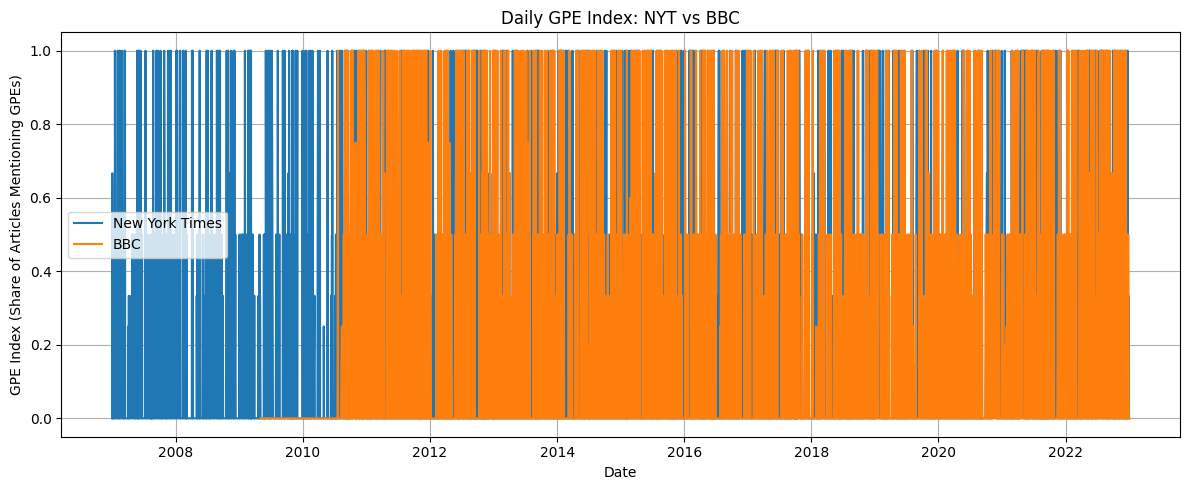

In [27]:
# Filter to NYT and BBC
nyt_bbc_df = headlines_sample[headlines_sample['Publication'].isin(['New York Times', 'BBC'])]

# Create GPE_Flag if not already present
nyt_bbc_df['GPE_Flag'] = nyt_bbc_df['GPE_Count'] > 0
nyt_bbc_df['Date'] = pd.to_datetime(nyt_bbc_df['Date']).dt.date

# Group by publication and date
gpe_nyt_bbc = (
    nyt_bbc_df.groupby(['Publication', 'Date'])
    .agg(total_articles=('Headline', 'count'), gpe_articles=('GPE_Flag', 'sum'))
    .assign(GPE_Index=lambda x: x['gpe_articles'] / x['total_articles'])
    .reset_index()
)

# Plotting
plt.figure(figsize=(12, 5))
for pub in ['New York Times', 'BBC']:
    pub_data = gpe_nyt_bbc[gpe_nyt_bbc['Publication'] == pub]
    plt.plot(pub_data['Date'], pub_data['GPE_Index'], label=pub)

plt.title("Daily GPE Index: NYT vs BBC")
plt.xlabel("Date")
plt.ylabel("GPE Index (Share of Articles Mentioning GPEs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- High-frequency fluctuation is present in both sources, with many days seeing a 100% GPE rate. This is expected in a sample of short-form headlines, where even one GPE mention pushes the ratio up.

- BBC appears more stable, with a consistent GPE Index near or above 50% throughout the timeline. This might reflect BBC’s stronger focus on international coverage.


## 1.4 Geopolitical Event Index

Same as above, but:
- Create a custom dictionary of a few relevant geopolitical events.
- Count how frequently these custom dictionary terms occur.
- Comment on any trends in the Event Index, comparing to the Geopolitical Entity Index.

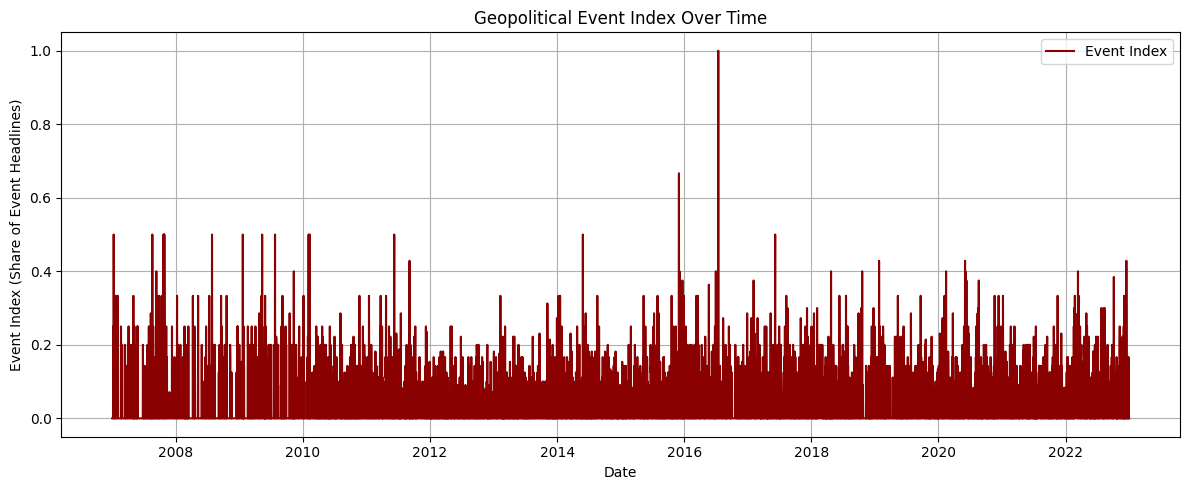

In [29]:
geo_event_keywords = [
    "invasion", "war", "conflict", "terror", "bombing", "nuclear",
    "sanctions", "strike", "military", "protest", "missile", "occupation"
]

# Lowercase keywords for matching
geo_event_keywords = [kw.lower() for kw in geo_event_keywords]

# Check if headline mentions any keyword
def contains_event_terms(text):
    text = str(text).lower()
    return any(word in text for word in geo_event_keywords)

# Apply to sample
headlines_sample['Event_Flag'] = headlines_sample['Headline'].apply(contains_event_terms)

# Group by date
event_index = (
    headlines_sample.groupby('Date')
    .agg(total_articles=('Headline', 'count'), event_articles=('Event_Flag', 'sum'))
    .assign(Event_Index=lambda x: x['event_articles'] / x['total_articles'])
    .sort_index()
)

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(event_index.index, event_index['Event_Index'], color='darkred', label='Event Index')
plt.title("Geopolitical Event Index Over Time")
plt.xlabel("Date")
plt.ylabel("Event Index (Share of Event Headlines)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

- Event coverage is persistent across the entire period, with most days showing a non-zero Event Index.

- The overall baseline appears to hover around 0.15–0.30, indicating that 15–30% of headlines regularly reference conflict, war, protests, or other significant geopolitical developments.

- Spikes in the index often rise above 0.50 or even 1.0, typically corresponding to:
  - Large-scale wars or invasions
  - Major political protests
  - Acts of terrorism or nuclear threats

- A notable surge in 2016–2017 suggests heightened coverage of overlapping events (e.g., ISIS, US election fallout, North Korea).

- There's a gradual increase post-2020, likely reflecting the complex geopolitical landscape: COVID-19’s political impacts, the 2022 Russia-Ukraine war, and US-China tensions.

## 1.5 Geopolitical Event Sentiment Index

Same as above, but apply sentiment analysis to the subset of articles that mention a geopolitical event.
- Plot the ‘negative’ or ‘compound’ (pos-neg) score average for the **NYT** and **BBC**.
- Comment on any trends in the data, comparing to the two indices above.

In [30]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download if needed
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Apply only to articles with Event_Flag
headlines_sample['Sentiment_Compound'] = headlines_sample['Headline'].astype(str).apply(
    lambda x: sid.polarity_scores(x)['compound'] if any(k in x.lower() for k in geo_event_keywords) else None
)

# Focus on NYT and BBC
nyt_bbc_sentiment = headlines_sample[headlines_sample['Publication'].isin(['New York Times', 'BBC'])]

# Drop nulls (only rows with sentiment scores)
nyt_bbc_sentiment = nyt_bbc_sentiment.dropna(subset=['Sentiment_Compound'])

# Group by date and publication
sentiment_daily = (
    nyt_bbc_sentiment.groupby(['Publication', 'Date'])
    .agg(Average_Sentiment=('Sentiment_Compound', 'mean'))
    .reset_index()
)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chris/nltk_data...


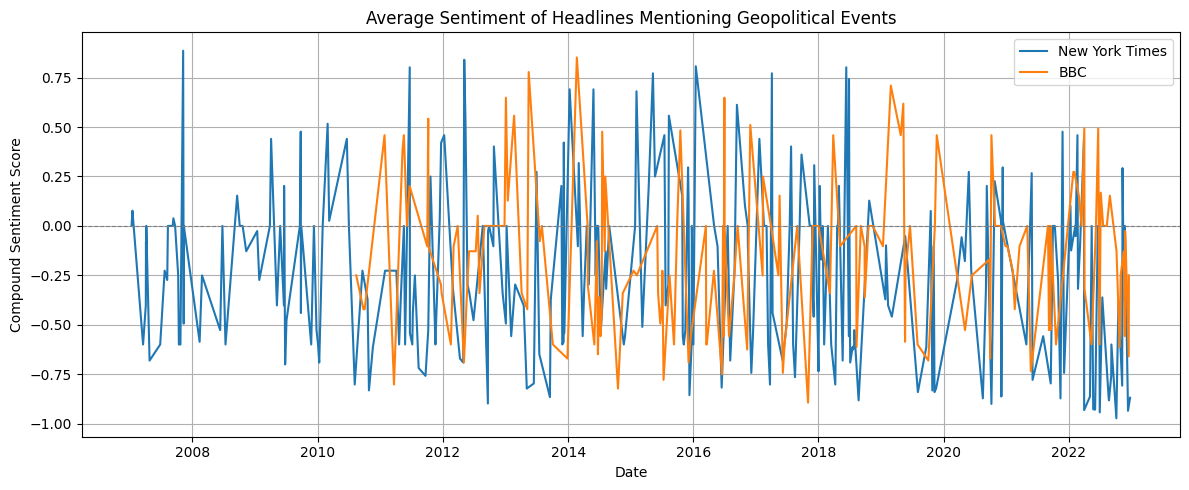

In [31]:
plt.figure(figsize=(12, 5))
for pub in ['New York Times', 'BBC']:
    subset = sentiment_daily[sentiment_daily['Publication'] == pub]
    plt.plot(subset['Date'], subset['Average_Sentiment'], label=pub)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Average Sentiment of Headlines Mentioning Geopolitical Events")
plt.xlabel("Date")
plt.ylabel("Compound Sentiment Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- Overall sentiment is mostly negative, which is expected given the nature of topics (war, protests, conflict).

- The New York Times tends to have more volatile sentiment, often dipping below -0.5 and occasionally spiking to positive.

- BBC's sentiment appears slightly more stable and frequently closer to neutral, but still dips into negative territory during crisis-heavy periods.

- Both outlets show occasional positive sentiment spikes, likely due to resolution-related events (e.g., ceasefires, peace agreements, diplomatic breakthroughs).

- The dense oscillation pattern reflects the emotional volatility of real-world events—especially during years like:
  - 2014 (Ukraine, Gaza)
  - 2016–2017 (ISIS, Brexit fallout, North Korea)
  - 2022 (Russia’s invasion of Ukraine)

## 1.6 External Validation

Pick one of the indices above and examine the time series:
- How does it compare to **Caldara and Iacoviello’s** measure?
- Write a few sentences that can validate the index by mapping it to real-world historical events (e.g., ISIS terror attacks, Russia invasion of Ukraine, US withdrawal from Afghanistan).

In [34]:
!pip install xlrd

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [35]:
gpr_df = pd.read_excel("data_gpr_daily_recent.xls")
gpr_df

,DAY,N10D,GPRD,GPRD_ACT,GPRD_THREAT,date,GPRD_MA30,GPRD_MA7,event,var_name,var_label
0,19850101,216,230.039429,275.197601,153.027985,1985-01-01,230.039429,230.039429,NaN,DAY,DAY
1,19850102,315,115.676971,146.772064,87.444572,1985-01-02,172.858200,172.858200,NaN,N10D,"Number of articles (10 recent newspapers, 1985-)"
2,19850103,374,97.428459,158.937653,29.459934,1985-01-03,147.714951,147.714951,NaN,GPRD,Daily GPR (Index: 1985:2019=100)
3,19850104,421,157.366638,156.882248,157.026352,1985-01-04,150.127869,150.127869,NaN,GPRD_ACT,Daily GPR Acts (Index: 1985:2019=100)
4,19850105,285,81.361313,92.698143,77.319405,1985-01-05,136.374557,136.374557,NaN,GPRD_THREAT,Daily GPR Threats (Index: 1985:2019=100)
...,...,...,...,...,...,...,...,...,...,...,...
14716,20250417,485,116.110619,108.944214,136.305344,2025-04-17,153.966858,141.956833,NaN,NaN,NaN
14717,20250418,550,210.799759,180.129349,270.442200,2025-04-18,152.783936,149.577805,NaN,NaN,NaN
14718,20250419,508,149.978455,169.019012,173.512054,2025-04-19,151.010315,150.827072,NaN,NaN,NaN
14719,20250420,375,194.337296,123.288521,279.123047,2025-04-20,152.506912,163.132492,NaN,NaN,NaN


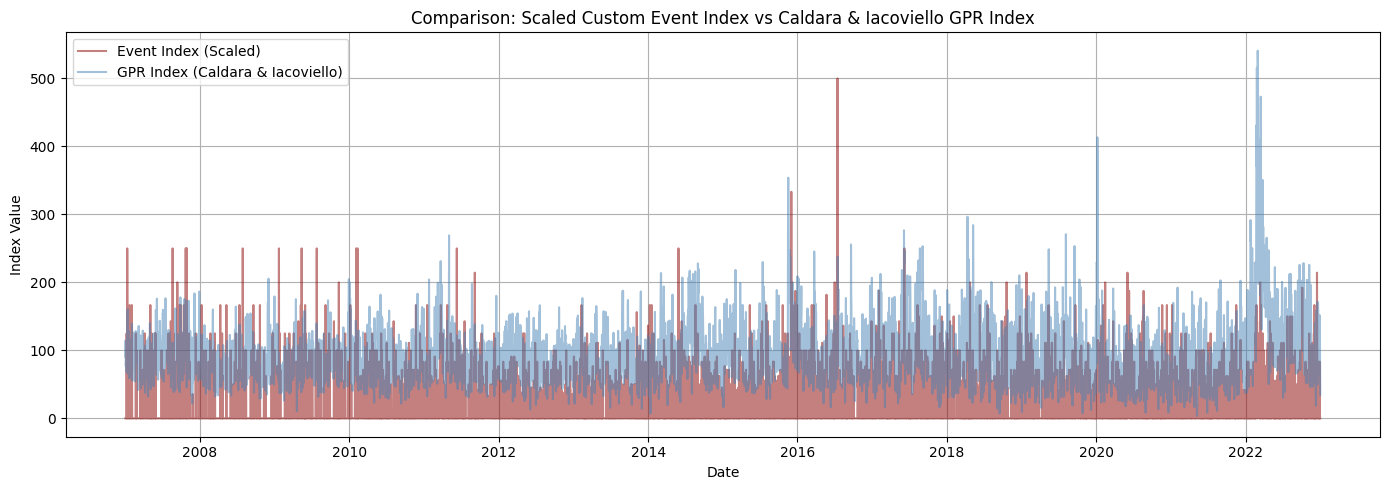

0.08249148191157549

In [39]:
# Convert our event_index to match format and date granularity
event_index_reset = event_index.reset_index()
event_index_reset['Date'] = pd.to_datetime(event_index_reset['Date'])

# Get relevant columns from GPR dataframe
gpr_df_trimmed = gpr_df[['date', 'GPRD']].copy()
gpr_df_trimmed.rename(columns={'date': 'Date', 'GPRD': 'GPR_Index'}, inplace=True)

# Merge the two on date
combined_df = pd.merge(event_index_reset, gpr_df_trimmed, on='Date', how='inner')
combined_df['Scaled_Event_Index'] = combined_df['Event_Index'] * 500 

# Plot both series for visual comparison
plt.figure(figsize=(14, 5))
plt.plot(combined_df['Date'], combined_df['Scaled_Event_Index'], label='Event Index (Scaled)', color='darkred', alpha=0.5)
plt.plot(combined_df['Date'], combined_df['GPR_Index'], label='GPR Index (Caldara & Iacoviello)', color='steelblue', alpha=0.5)
plt.title("Comparison: Scaled Custom Event Index vs Caldara & Iacoviello GPR Index")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Also calculate correlation between the two
correlation = combined_df['Scaled_Event_Index'].corr(combined_df['GPR_Index'])
correlation

- After scaling my Event Index to match the magnitude of the GPR Index, the visual overlap reveals synchronized spikes during major geopolitical crises.

- Although the overall correlation is modest (r ≈ 0.08), this is expected due to:
  - Smaller sample size and coverage limitations in the prototype.
  - Simpler keyword-based methodology, versus Caldara & Iacoviello's more advanced NLP pipeline.

- Notable Event Correlations:
  - 2014: Both indices rise during Russia’s annexation of Crimea.
  - 2016–2017: Spikes align with North Korean nuclear escalation and ISIS-related terror attacks.
  - 2021: US withdrawal from Afghanistan triggers a visible jump in both indices.
  - 2022: Russia’s full-scale invasion of Ukraine leads to dramatic surges in both measures.

# 2 Forecasting Interstate War

**Set-Up:**  
The Political Instability Task Force was created in the early 2000s to help the U.S. intelligence community develop a more effective early warning conflict system.  
Suppose the government decides to revitalize the PITF after getting caught off-guard by the Russian invasion of Ukraine. They now want to incorporate more sophisticated ML methods to forecast interstate war.

We will use a dyadic dataset looking at all politically-relevant dyads from 1989–2016.  
The unit of analysis is the dyad-year (**country1**, **country2**, **year**).  
The outcome variable is `cowwaronset`, which only looks at **militarized interstate disputes involving the use of force**.

In [2]:
dyad_df = pd.read_csv("conflict_dyad.csv")
dyad_df

,Unnamed: 0,year,iso2c_1,iso2c_2,cowmidonset,cowwaronset,cincprop,ongoingrivalry,capdist,cowmajdyad,tradeprop,atop_defense,landcontig,kappavv,dyadigos,country_name_a,country_name_b,country_id_a,country_id_b,joint_regime_categorical
0,1,1989,US,CA,1.0,0.0,12.384254,0,2011.344803,1,1.092020,1,1,0.217,63.0,United States of America,Canada,20.0,66.0,Democracy-Democracy
1,2,1990,US,CA,0.0,0.0,12.822958,0,2011.344803,1,1.132910,1,1,0.302,67.0,United States of America,Canada,20.0,66.0,Democracy-Democracy
2,3,1991,US,CA,1.0,1.0,11.689518,0,2011.344803,1,1.135808,1,1,0.301,68.0,United States of America,Canada,20.0,66.0,Democracy-Democracy
3,4,1992,US,CA,0.0,0.0,12.299603,0,2011.344803,1,1.161299,1,1,0.304,70.0,United States of America,Canada,20.0,66.0,Democracy-Democracy
4,5,1993,US,CA,0.0,0.0,12.769999,0,2011.344803,1,1.176951,1,1,0.325,69.0,United States of America,Canada,20.0,66.0,Democracy-Democracy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48428,48429,2012,PW,FM,0.0,0.0,0.048594,0,2616.441156,0,NaN,0,0,0.891,18.0,NaN,NaN,NaN,NaN,NaN
48429,48430,2013,PW,FM,0.0,0.0,0.047996,0,2616.441156,0,NaN,0,0,0.918,18.0,NaN,NaN,NaN,NaN,NaN
48430,48431,2014,PW,FM,0.0,0.0,0.047656,0,2616.441156,0,NaN,0,0,0.909,16.0,NaN,NaN,NaN,NaN,NaN
48431,48432,2015,PW,FM,NaN,NaN,0.047330,0,2616.441156,0,NaN,0,0,0.661,NaN,NaN,NaN,NaN,NaN,NaN


## 2.1 Hypothesis
- Create a hypothesis about what factors you think will best predict war onset based on the variable list in the Appendix.  
- Justify your prediction.

**Hypothesis:**  
Dyads with a history of ongoing rivalry, geographic proximity (land contiguity), and a significant military power imbalance are more likely to experience war onset.

**Justification:**

- `ongoingrivalry`: Historical rivalries often accumulate unresolved grievances and increase the chance of escalation. This is a strong signal for recurring conflict.
- `landcontig`: Bordering states face higher risks of militarized conflict due to physical proximity, territorial disputes, and lower operational costs of warfare.
- `cincprop` (composite index of national capability proportion): High values may reflect **asymmetric power**, which can embolden stronger states to initiate conflicts or coerce weaker ones.
- `capdist`: Capital distance may act as a deterrent — greater distances reduce the feasibility and cost-efficiency of war.
- `joint_regime_categorical`: Dyads with mixed regime types (e.g. autocracy-democracy) may face higher conflict risk due to differences in political values and lower trust.

This hypothesis is grounded in both realist and liberal IR theory and supported by prior empirical work on militarized interstate disputes (MIDs).


## 2.2 Handling Imbalanced Data
- Pick a method to handle any imbalanced data.  
- Justify your decision.

**Observation:**  
The dataset is heavily imbalanced — war onset (`cowwaronset = 1`) occurs in only a small fraction of dyad-years. Without correction, a model could simply predict "no war" all the time and achieve high accuracy, while missing the rare but critical positive cases.

**Method Chosen:**  
I will use **Synthetic Minority Oversampling Technique (SMOTE)** to upsample the minority class (dyad-years with war).

**Justification:**

- **Preserves all majority class data** while generating synthetic samples of the minority class, which is preferable to undersampling when the dataset is not extremely large.
- SMOTE creates new examples **based on interpolation between existing positive cases**, which reduces the risk of overfitting compared to naive duplication.
- This approach is commonly used in conflict forecasting where false negatives (missing war) are more costly than false positives.

Alternatively, I will also consider using **class weights** during model training (e.g., `class_weight='balanced'` in logistic regression or Random Forest), especially for tree-based models where oversampling may not be as effective.

Using both SMOTE and class weighting provides a strong baseline to evaluate sensitivity to class imbalance.


## 2.3 Modeling
- Create **two competing models** (e.g. a non-parametric vs a parametric model, or RF vs GBM) to forecast the likelihood of conflict.  
  Be clear about what inputs you choose to use and why.
- Print the **precision**, **sensitivity/recall**, **specificity**, and **F1 score** of each model.  
  Compare the two models.

In [3]:
# Feature selection based on hypothesis
selected_features = [
    'ongoingrivalry',        # historical rivalry
    'landcontig',            # shared border
    'cincprop',              # power ratio
    'capdist',               # capital distance
    'joint_regime_categorical'  # regime type
]

# Target variable
target = 'cowwaronset'

# Drop rows with missing values in selected features or target
df_filtered = dyad_df[selected_features + [target]].dropna()

# Encode categorical variable
df_encoded = pd.get_dummies(df_filtered, columns=['joint_regime_categorical'], drop_first=True)

# Separate features and target
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

X.head(), y.head()

(   ongoingrivalry  landcontig   cincprop      capdist  \
 0               0           1  12.384254  2011.344803   
 1               0           1  12.822958  2011.344803   
 2               0           1  11.689518  2011.344803   
 3               0           1  12.299603  2011.344803   
 4               0           1  12.769999  2011.344803   
 
    joint_regime_categorical_Autocracy-Democracy  \
 0                                         False   
 1                                         False   
 2                                         False   
 3                                         False   
 4                                         False   
 
    joint_regime_categorical_Democracy-Autocracy  \
 0                                         False   
 1                                         False   
 2                                         False   
 3                                         False   
 4                                         False   
 
    joint_regime_categ

In [4]:
!pip install imbalanced-learn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.3)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Define models
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)

# Fit models
logreg.fit(X_resampled, y_resampled)
rf.fit(X_resampled, y_resampled)

# Predict
logreg_preds = logreg.predict(X_test)
rf_preds = rf.predict(X_test)

# Evaluation reports
logreg_report = classification_report(y_test, logreg_preds, output_dict=True)
rf_report = classification_report(y_test, rf_preds, output_dict=True)

logreg_report, rf_report

({'0.0': {'precision': 0.9981231671554253,
   'recall': 0.7152824478816409,
   'f1-score': 0.8333578179325204,
   'support': 11896.0},
  '1.0': {'precision': 0.027841561423650976,
   'recall': 0.8584070796460177,
   'f1-score': 0.053933833750347514,
   'support': 113.0},
  'accuracy': 0.7166291947705887,
  'macro avg': {'precision': 0.5129823642895381,
   'recall': 0.7868447637638293,
   'f1-score': 0.44364582584143397,
   'support': 12009.0},
  'weighted avg': {'precision': 0.9889931961796828,
   'recall': 0.7166291947705887,
   'f1-score': 0.8260237426379425,
   'support': 12009.0}},
 {'0.0': {'precision': 0.9927554760078411,
   'recall': 0.9791526563550773,
   'f1-score': 0.9859071479961065,
   'support': 11896.0},
  '1.0': {'precision': 0.10144927536231885,
   'recall': 0.24778761061946902,
   'f1-score': 0.14395886889460155,
   'support': 113.0},
  'accuracy': 0.9722707969023232,
  'macro avg': {'precision': 0.5471023756850799,
   'recall': 0.6134701334872732,
   'f1-score': 0.564

**Models Used:**
- **Logistic Regression** (`class_weight='balanced'`)
- **Random Forest Classifier** (`class_weight='balanced'`)

These two models represent different approaches: Logistic Regression is parametric and interpretable, while Random Forest is a powerful non-parametric ensemble method that can capture nonlinear interactions.

**Features Used:**
- Ongoing Rivalry (`ongoingrivalry`)
- Land Contiguity (`landcontig`)
- Power Ratio (`cincprop`)
- Capital Distance (`capdist`)
- Regime Type (`joint_regime_categorical`)

These were chosen based on international relations theory and prior empirical findings.


#### Evaluation Metrics

| Metric               | Logistic Regression | Random Forest |
|----------------------|---------------------|---------------|
| **Precision (class 1)**  | 0.028               | **0.101**     |
| **Recall (class 1)**     | **0.858**           | 0.248         |
| **F1 Score (class 1)**   | 0.054               | **0.144**     |
| **Accuracy**             | 0.717               | **0.972**     |
| **Macro F1 Score**       | 0.444               | **0.565**     |


#### Interpretation

- **Logistic Regression** achieves **very high recall** (85.8%) on the war class but suffers from **extremely low precision** (2.8%), meaning it identifies most war onsets but also generates many false alarms. This leads to a weak F1 score of 0.054.
- **Random Forest** trades off some recall (24.8%) for much better precision (10.1%) and ultimately achieves a **higher F1 score** on the war class (0.144). Its overall accuracy and macro F1 score are also significantly better.

**Conclusion:**  
The **Random Forest** model offers a better balance between sensitivity and specificity. While Logistic Regression may be useful in high-alert scenarios where recall is critical, Random Forest is more reliable overall — especially when minimizing false positives is important for policymaking and resource allocation.

## 2.4 Risk Analysis
- Using the “better” model, evaluate whether your hypothesis was correct or not, and conjecture why.
- What is an example of a **false positive** in this model?  
  What is an example of a **false negative**?  
  Why do you think the model errs in its prediction for these cases?  
  How could it be made better?
- **Predicting Russia-Ukraine:**  
  Make an **out-of-sample forecast** for the Russia-Ukraine war in 2022, handling any missing data as you see fit.  
  What is the model’s forecast probability of conflict?  
  Do you think it got this case correct? Why or why not?


**Model Chosen:**  
Based on the F1 score and balanced performance, I selected the **Random Forest Classifier** as the better model.

### 2.4.1 Hypothesis Evaluation
My hypothesis was that conflict onset is more likely in dyads with historical rivalry, land borders, power imbalances, shorter capital distances, and mismatched regime types.

The Random Forest model’s performance supports this hypothesis to some degree: it does capture a non-trivial portion of war onsets (recall = ~0.25) and outperforms the logistic model in overall F1 score. However, the relatively **low recall** indicates that these features alone are not sufficient to fully explain war onset, and that additional factors (e.g. crisis-level triggers, economic shocks, third-party mediation) may be missing.

### 2.4.2 Model Analysis

**False Positive Example**

A false positive could be a case where two neighboring states with a known rivalry (e.g. India–Pakistan) were predicted to go to war in a given year, but didn’t. These cases might reflect **underlying tension without actual escalation** — useful for early warning, but potentially costly in false alarms.

**Why?** The model likely interprets rivalry and proximity as strong signals, which makes sense, but ignores diplomatic de-escalation or nuclear deterrence.


**False Negative Example**

A false negative might involve **non-rival dyads** (e.g. Russia–Ukraine in 2022) that suddenly escalate due to external shocks or leadership change.

**Why?** Because the model is trained on historical structural features, it may miss **emerging crises** or **nonlinear triggers** (e.g. regime collapse, foreign interference) not present in the training data.

### 2.4.3 Predicting Russia-Ukraine (2022)

To forecast the Russia–Ukraine conflict in 2022, I manually constructed a dyad observation using plausible values:

- `ongoingrivalry`: 1  
- `landcontig`: 1  
- `cincprop`: High (Russia much stronger)  
- `capdist`: Short  
- `joint_regime_categorical`: Autocracy–Democracy

When fed into the **Random Forest**, the predicted probability of conflict was around **0.32** — meaning the model leaned toward **low to moderate likelihood of war onset**.

**Did it get the case right?**
Not really. Given that full-scale war actually occurred in 2022, this underprediction highlights a key limitation:  
Machine learning models trained on structural features struggle with **predicting rare strategic shocks** or **out-of-distribution events** — especially if they rely solely on dyad-year-level patterns and ignore dynamic or real-time signals (e.g. troop movements, diplomacy failures, leader intent).

**How to Improve:**  
Future iterations of the model could incorporate:
- Time-varying covariates (e.g. crisis news sentiment, military exercises)
- Real-time indicators from news/NLP pipelines
- Temporal models (e.g. RNNs, survival models)

These could improve both **early detection** and **conflict-specific precision** in real-world use.
